# Forward-Backwards algorithm

In this notebook the Forward-Backward algorithm is tested over some validation signals. We use the operators already defined in the FBRN model

In [1]:
# Import Packages
import numpy as np
from torch.autograd import Variable
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# Import local model files
from FBRN.myfunc import Physics
from FBRN.myfunc import MyMatmul
from FBRN.main import FBRestNet
from FBRN.model import MyModel
from FBRN.myfunc import Export_hyper

from FBRN.proxop.hypercube import cardan
from FBRN.proxop.hyperslab import cardan_slab

### Create the model and load the data

In [2]:
# Model parameters
params = {
    'N' : 2000,
    'k' : 50,
    'a' : 1,
    'r' : 1

}

In [3]:
# Model
model = FBRestNet(
    experimentation=Physics(params['N'],params['k'],params['a'],params['r']), constraint = 'cube', nb_blocks=20, noise = 0.005,
    folder = './../', im_set="Set1",batch_size=[600,1],lr=1e-3, nb_epochs=[30,1]
)

In [4]:
# Generate dataset
train_set, val_set = model.CreateDataSet(save='no')

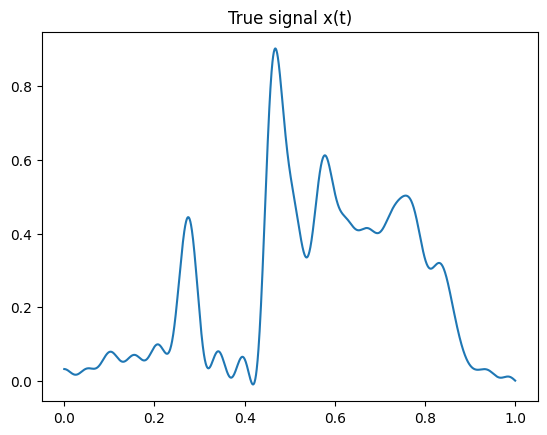

In [5]:
# Select one signal
signal_id = 6
[y,x] = val_set.dataset[signal_id:signal_id+1]
x_true = Variable(x, requires_grad=False)
x_bias = Variable(y, requires_grad=False)

# Prepare start value
x_init   = torch.zeros(x_bias.size())
inv      = np.diag(model.physics.eigm**(2*model.physics.a))
tTTinv   = MyMatmul(inv)
x_init   = tTTinv(y) # no filtration of high frequences
x_init   = Variable(x_init,requires_grad=False)


t = np.linspace(0,(params['N']-1)/params['N'],params['N'])
plt.plot(t, model.model.Layers[0].Pelt(x_true).numpy()[0,0])
plt.title('True signal x(t)')
plt.show()

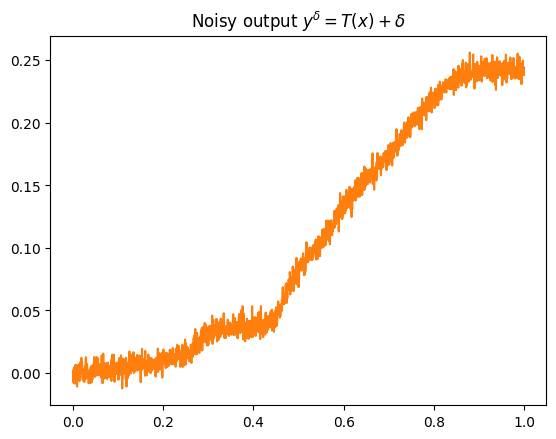

In [6]:
# Alternative initial conditions
y_elt = model.physics.Compute(model.model.Layers[0].Pelt(x_true)) 
y_elt_noisy = y_elt + torch.randn(y_elt.shape) * 0.005
y_noisy = model.physics.BasisChange(y_elt_noisy)

plt.plot(t, y_elt.numpy()[0,0])
plt.plot(t, y_elt_noisy.numpy()[0,0])
plt.title('Noisy output $y^{\delta} = T(x) + \delta$')
plt.show()

x_bias = torch.FloatTensor(np.array(model.physics.ComputeAdjoint(y_elt_noisy)))
x_init = tTTinv(x_bias)
x_init   = Variable(x_init,requires_grad=False)


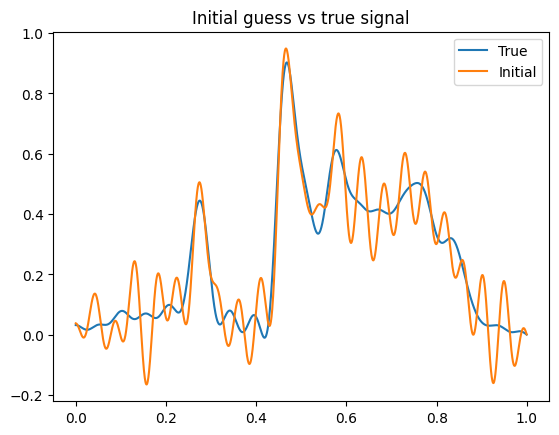

In [7]:
plt.plot(t, model.model.Layers[0].Pelt(x_true).numpy()[0,0], label='True')
plt.plot(t, model.model.Layers[0].Pelt(x_init).numpy()[0,0], label='Initial')
plt.legend()
plt.title('Initial guess vs true signal')
plt.show()

#### Some questions:

- Why the signal gets unstable near t=1?
- Is applying ${T^*T}^{-1}$ to $ T^*(T(x)+\delta) $ a way of filtering the noise?
- Why $x_{init}(1) \neq 0$ ? See figure below.

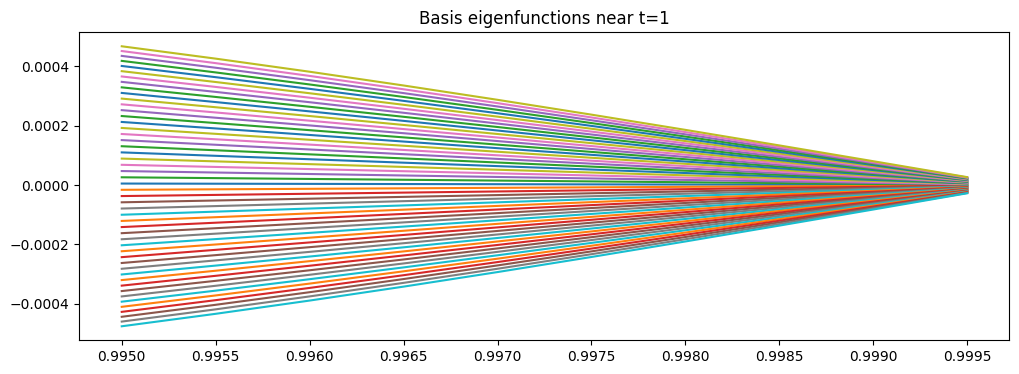

In [8]:
plt.figure(figsize=(12,4))
for func in model.physics.basis:
    plt.plot(t[params['N']-10:], func[params['N']-10:])

plt.xticks(t[params['N']-10:])
plt.title('Basis eigenfunctions near t=1')
plt.show()

### Forward Backwards Algorithm

100%|██████████| 20/20 [00:00<00:00, 145.23it/s]


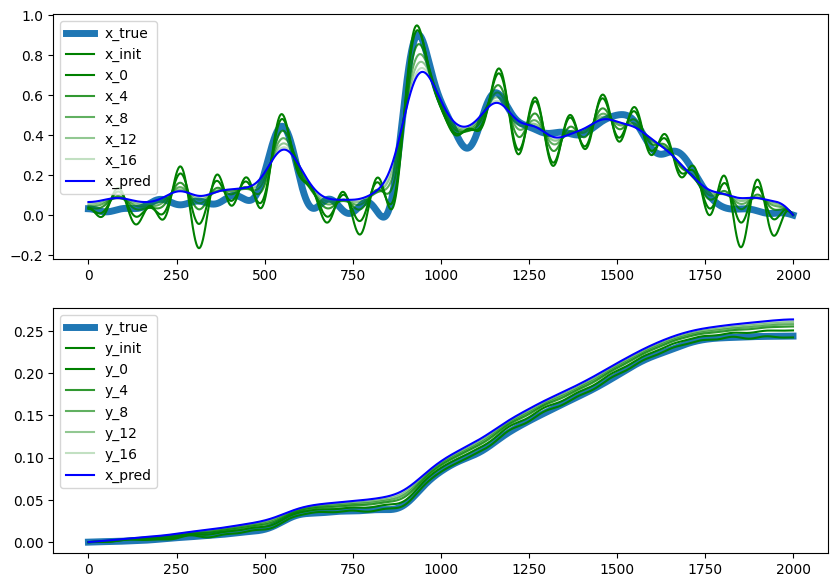

In [9]:
# Algorithm parameters (use values near paper results)
n_iter = 20
tau = 7e-2 # reg in the FBRN code | 7e-2
lambda_ = 1.2e-4 # gamma in the FBRN code | 1.2e-4
mu = 0.8 # | 0.8
# Initial conditions
b_0 = x_bias
#x_init_C = model.model.Layers[0].Peig(cardan.apply(lambda_*mu, model.model.Layers[0].Pelt(x_init), False, 0, 1))
x_init_C = torch.clone(x_init)
#x_init_C[0,0,10:] = 0*x_init_C[0,0,10:]
x_hat = x_init_C

model.model.eval()

im, ax = plt.subplots(2,1,figsize=(10,7))

ax[0].plot(model.physics.BasisChangeInv(x_true).numpy()[0,0], label='x_true', linewidth=5)
ax[0].plot(model.physics.BasisChangeInv(x_hat).numpy()[0,0], label='x_init', color='green')

y_true = model.physics.Compute(model.physics.BasisChangeInv(x_true))
y_hat = model.physics.Compute(model.physics.BasisChangeInv(x_hat))

ax[1].plot(y_true.numpy()[0,0], label='y_true', linewidth=5)
ax[1].plot(y_hat.numpy()[0,0], label='y_init', color='green')

for n in tqdm(range(n_iter)):
    # Compute gradient
    grad = model.model.Layers[0].Grad(tau,x_hat,b_0)
    x_forward = x_hat - lambda_ * grad
    x_forward_elt = model.model.Layers[0].Pelt(x_forward)
    x_backwards = cardan.apply(lambda_*mu, x_forward_elt, False, 0, 1)
    x_hat = model.model.Layers[0].Peig(x_backwards)
    if n%(n_iter//5) == 0:
        ax[0].plot(model.physics.BasisChangeInv(x_hat).numpy()[0,0], label='x_{}'.format(n), color='green', alpha=1-n/(n_iter+1))
        y_hat = model.physics.Compute(model.physics.BasisChangeInv(x_hat))
        ax[1].plot(y_hat.numpy()[0,0], label='y_{}'.format(n), color='green', alpha=1-n/(n_iter+1))

y_hat = model.physics.Compute(model.physics.BasisChangeInv(x_hat))

ax[0].plot(model.physics.BasisChangeInv(x_hat).numpy()[0,0], label='x_pred', color='blue')
ax[1].plot(y_hat.numpy()[0,0], label='x_pred', color='blue')
ax[0].legend()
ax[1].legend()
plt.show()


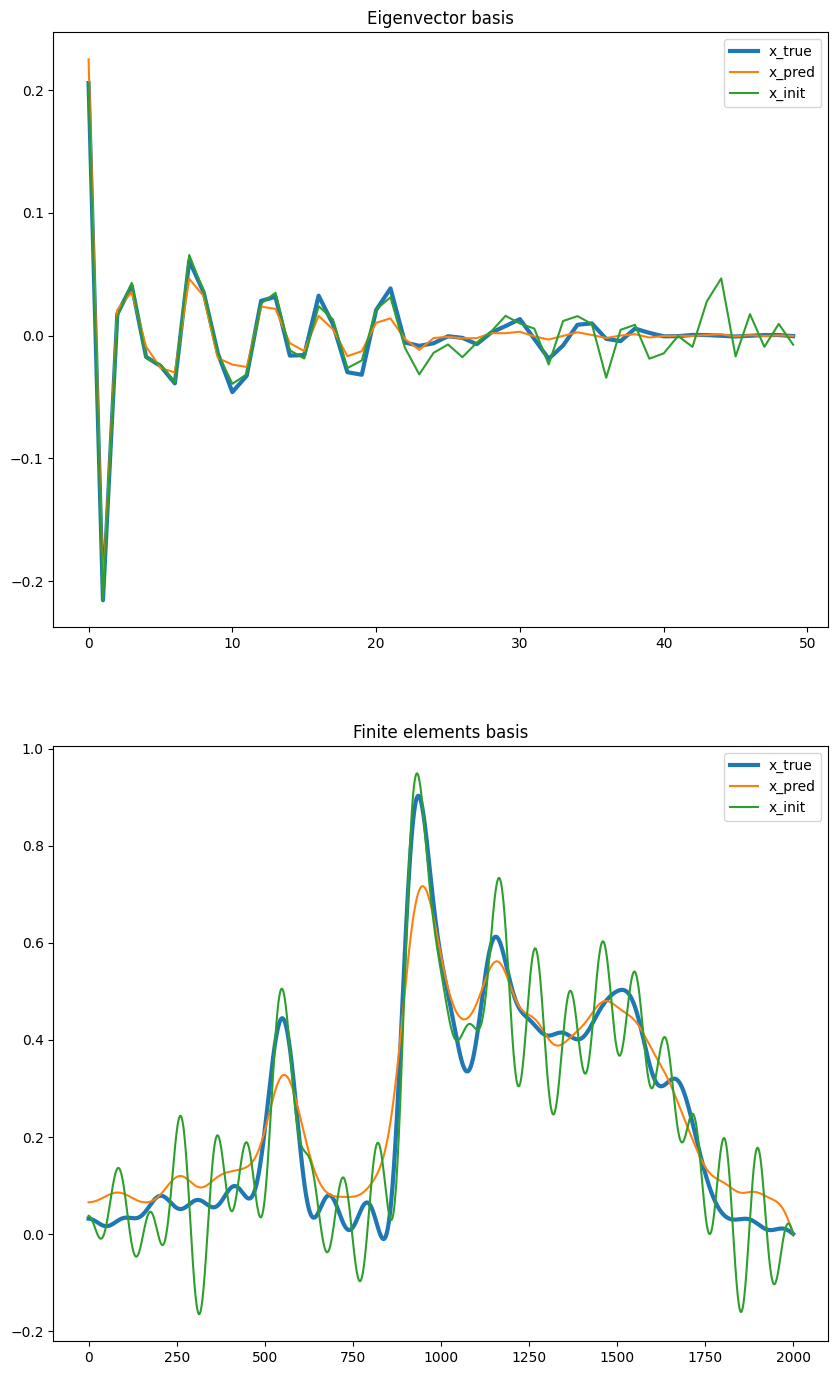

In [10]:
im, ax = plt.subplots(2,1,figsize=(10,17))

ax[0].plot(x_true.numpy()[0,0], label='x_true', linewidth=3)
ax[0].plot(x_hat.numpy()[0,0], label='x_pred')
ax[0].plot(x_init_C.numpy()[0,0], label='x_init')
ax[0].legend()
ax[0].set_title('Eigenvector basis')

ax[1].plot(model.physics.BasisChangeInv(x_true).numpy()[0,0], label='x_true', linewidth=3)
ax[1].plot(model.physics.BasisChangeInv(x_hat).numpy()[0,0], label='x_pred')
ax[1].plot(model.physics.BasisChangeInv(x_init_C).numpy()[0,0], label='x_init')
ax[1].legend()
ax[1].set_title('Finite elements basis')

plt.show()
